In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import numpy as np
import pandas as pd
import xarray as xr

In [2]:
def clip_extended_ocean_grid(obj, x0=139, y0=133):
    nx = 1280
    ny = 720
    
    new = obj.isel(x=slice(x0, x0 + nx),
                   y=slice(y0, y0 + ny))
    new['x'] = np.arange(new.dims['x'])
    new['y'] = np.arange(new.dims['y'])
    
    return new

In [3]:

# Open RASM ocean file
ds_mod = xr.open_dataset('/raid2/jhamman/projects/RASM/data/processed/R1009RBRbslr01a/ocn/monthly_mean_timeseries/R1009RBRbslr01a.pop.hmm.197909-201412.nc',
                     decode_times=False, chunks={'time': 3}).rename({'nlon': 'x', 'nlat': 'y', 'z_t': 'depth'})
ds_mod['time'] = pd.period_range('1979-09', '2014-12', freq='M')
ds_mod['depth'] /= 100  # convert to m from cm

# open PHC "Observations" 
ds_obs = xr.open_dataset('/raid2/jhamman/projects/RASM/data/compare/phc/phc3.0_monthly_ar9v4.nc',
                         decode_times=False).rename({'salt': 'SALT', 'temp': 'TEMP'})
ds_obs = clip_extended_ocean_grid(ds_obs)
ds_obs['time'] = pd.period_range('1979-09', freq='M', periods=12)


# open masks on ocean grid
ds_masks = xr.open_dataset('/raid2/jhamman/projects/RASM/data/inputdata/RASM_POPCICE_GRID_MASKS_AND_METRICS.nc')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


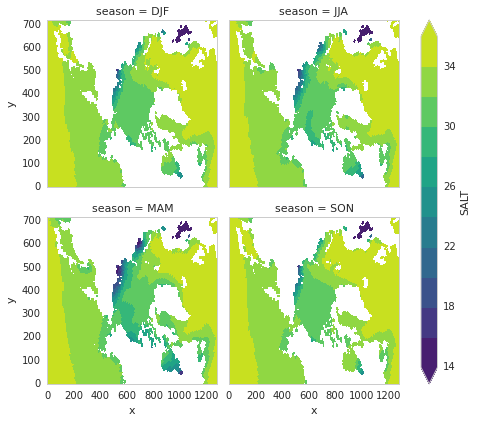

In [4]:
plot_kwargs = dict(col='season', col_wrap=2, vmin=15, vmax=35, levels=12, extend='both')

da_obs = ds_obs.SALT.isel(depth=0).groupby('time.season').mean('time')
da_obs.plot(**plot_kwargs)

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


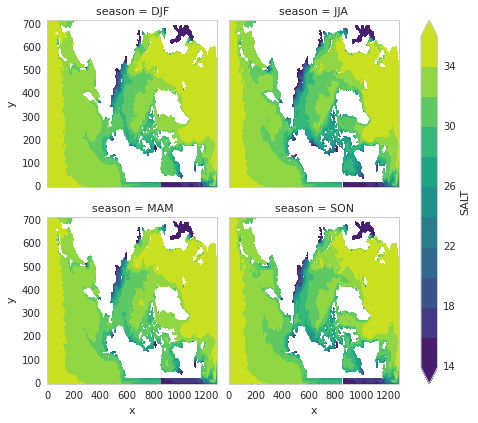

In [5]:
da_mod = ds_mod.SALT.isel(depth=0).sel(time=slice('1989-09', '1991-08')).groupby('time.season').mean('time')
da_mod.plot(**plot_kwargs)

In [6]:
diff_args = dict(col='season', col_wrap=2, levels=11, center=True, robust=True, extend='both')
diff = da_mod - da_obs

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


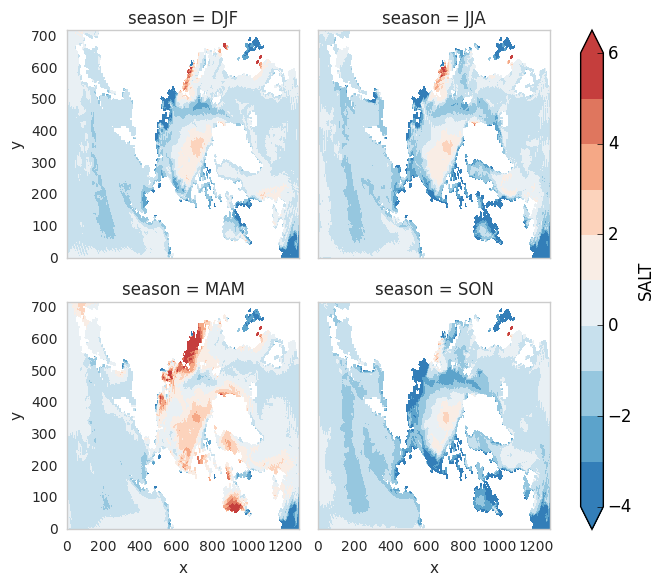

In [7]:
diff.plot(**diff_args)

In [28]:
masks = ['mask_archipelago', 'mask_atlantic', 'mask_baffin', 'mask_baltic', 'mask_barents', 
         'mask_bering', 'mask_canada', 'mask_centralarctic', 'mask_denmarkstrait', 'mask_greenland', 
         'mask_hudsonbay', 'mask_japan', 'mask_kara', 'mask_labrador', 'mask_nansen', 
         'mask_northsea', 'mask_norwegian', 'mask_okhotsk', 'mask_pacific', 'mask_shelf']

masks = ['mask_kara', 'mask_barents', 'mask_shelf', 'mask_canada', 'mask_centralarctic']

seasons = ['DJF', 'MAM', 'JJA', 'SON']

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: in

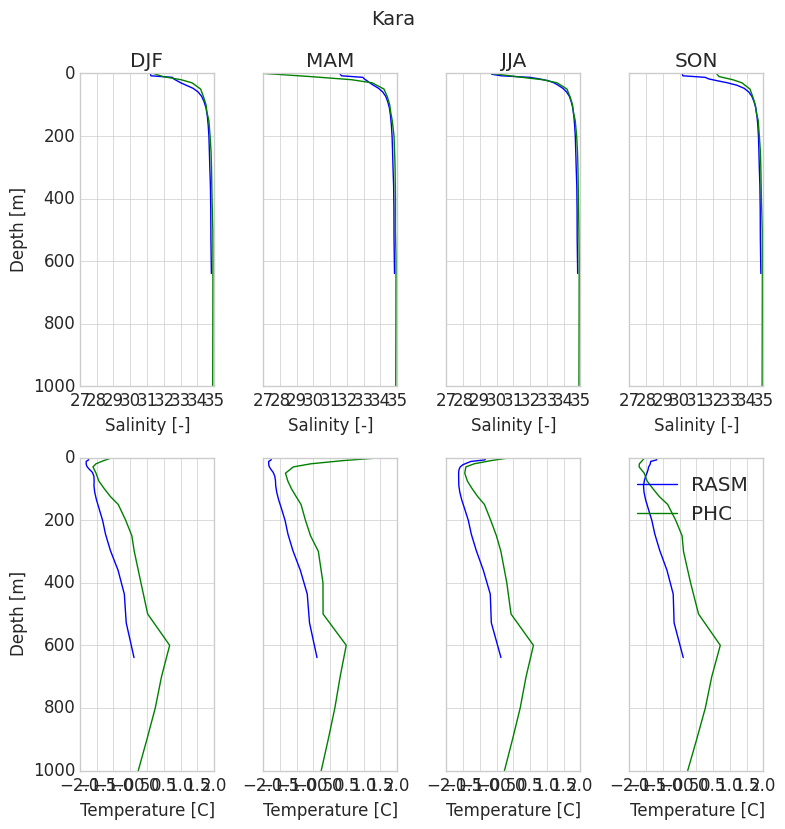

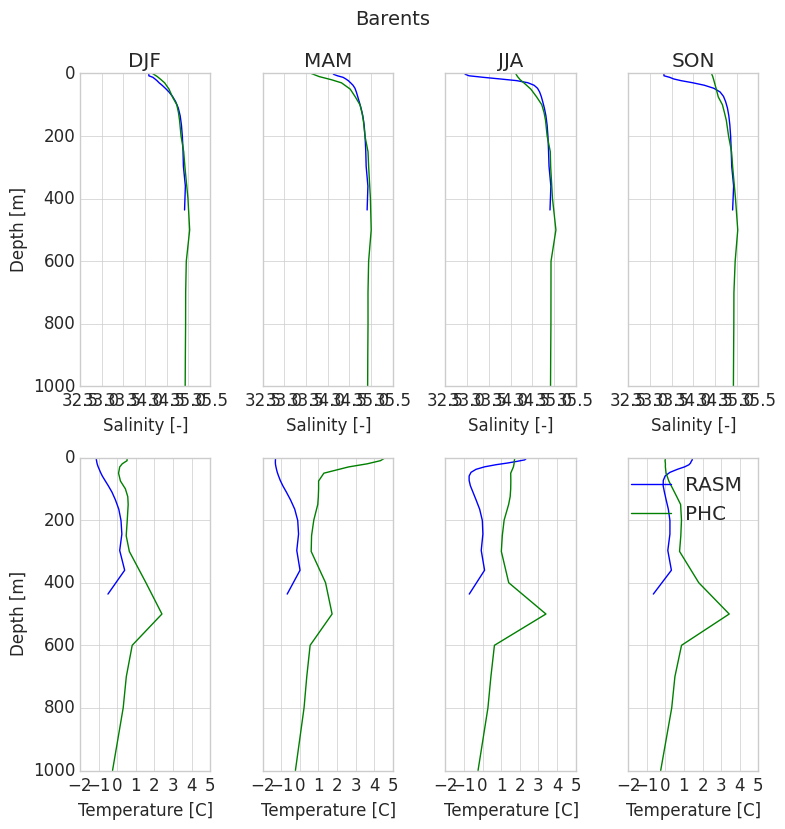

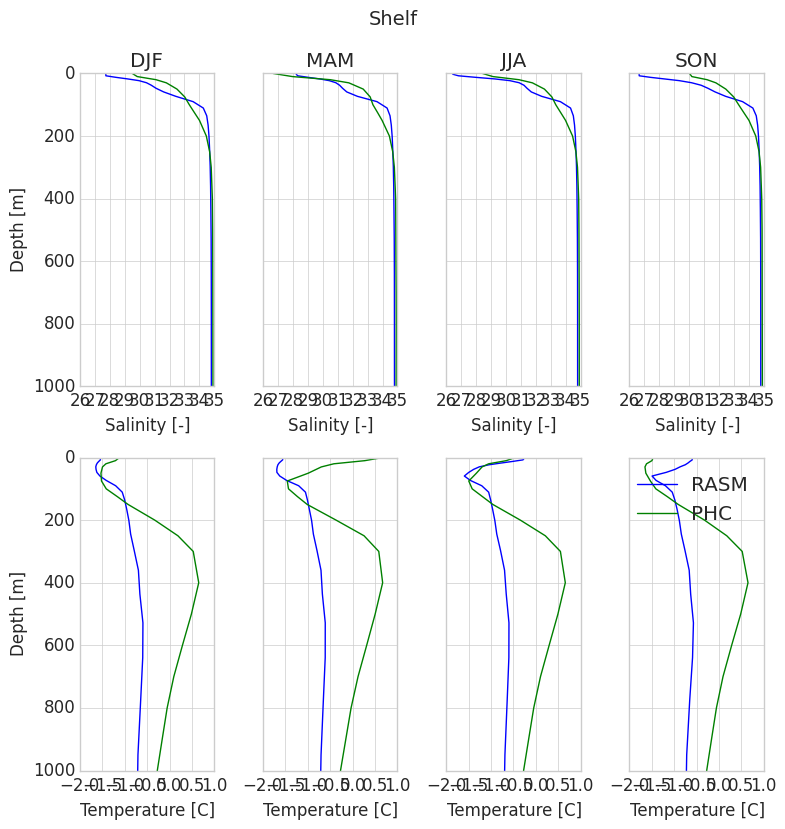

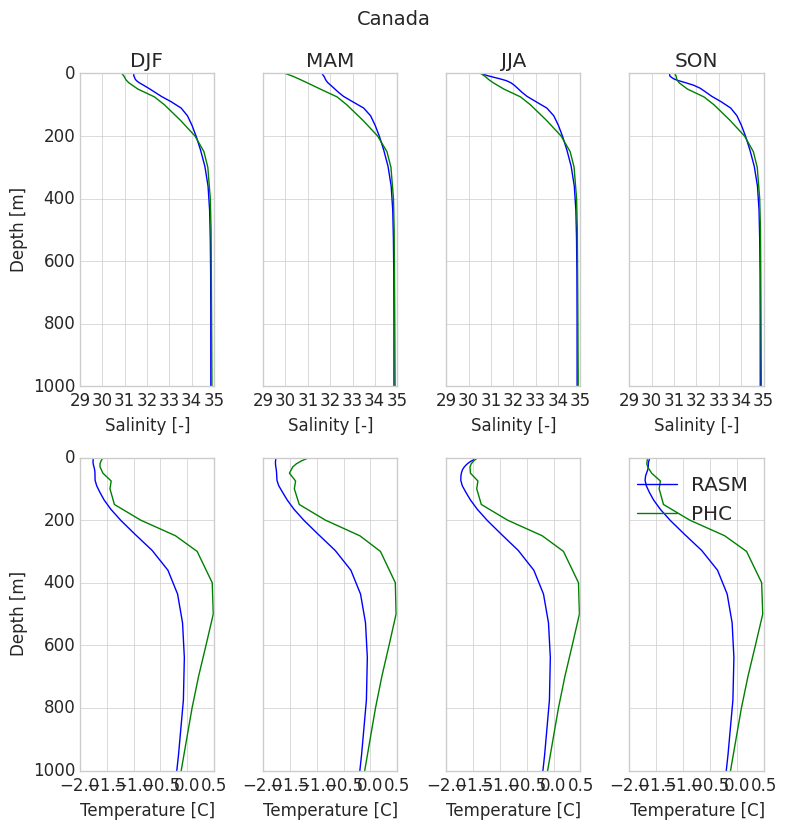

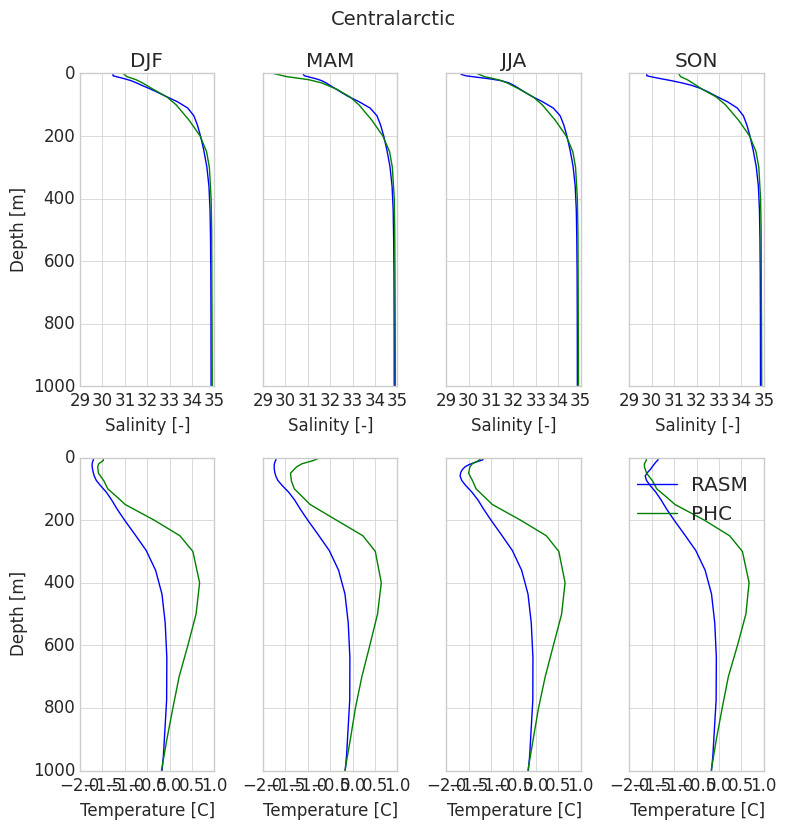

In [29]:
sns.set_style('whitegrid')

ds_seas_mod = ds_mod.sel(time=slice('1989-09', '1999-08')).groupby('time.season').mean('time')
ds_seas_obs = ds_obs.groupby('time.season').mean('time')

for mask in masks:

    fig, axes = plt.subplots(nrows=2, ncols=4, sharex='row', sharey=True, figsize=(8, 8))

    for i, var in enumerate(('SALT', 'TEMP')):
    
        for j, season, in enumerate(seasons):
            
            ax = axes[i, j]
            plt.sca(ax)      
            for ds, label in ((ds_seas_mod, 'RASM'), (ds_seas_obs, 'PHC')):
                
                da = ds[var].sel(season=season).where(ds_masks[mask] == 1).mean(dim=('x', 'y'))
           
                ax.plot(da.values, da['depth'].values, label=label)
            

#     [ax.set_xlim(26, 36) for ax in axes[0, :]]
#     [ax.set_xlim(-3, 3) for ax in axes[1, :]]
    [ax.set_ylabel('Depth [m]') for ax in axes[:, 0]]
    [ax.set_xlabel('Temperature [C]') for ax in axes[1, :]]
    [ax.set_xlabel('Salinity [-]') for ax in axes[0, :]]
    [ax.set_title(title) for ax, title in zip(axes[0, :], seasons)]
    axes[0, 0].set_ylim(0, 1000)
    axes[0, 0].invert_yaxis()
    plt.legend()
    fig.suptitle(' '.join(mask.split('_')[1:]).title(), y='1.03', fontsize=14)
    plt.tight_layout()
